## Perkenalan

---
Nama : Rangga Irwanto Putra Kiat
---

*  Problem Statement (Computer Vision)

1. URL Dataset
[https://www.kaggle.com/datasets/utkarshsaxenadn/shoes-classification-dataset-13k-images/data?select=Shoes+Dataset]

2. Problem yang Hendak Diselesaikan
Menciptakan Model Klasifikasi Citra Sepatu Otomatis Berbasis (Artificial Neural Network) (ANN) untuk meningkatkan efisiensi operasional di industri e-commerce fashion.

Model ini akan mampu mengidentifikasi dan mengkategorikan jenis sepatu (dari 5 kelas yang dipilih) secara instan, menggantikan proses tagging dan sortasi manual yang memakan waktu dan rentan kesalahan.

3. Justifikasi Bahwa Kasus Tersebut Ada dan Perlu Diselesaikan
Dalam industri e-commerce dan retail fesyen, inventaris produk yang masif memerlukan sistem manajemen yang sangat efisien. Klasifikasi produk yang tidak tepat (misalnya, sepatu (sneaker) dikategorikan sebagai sepatu formal) dapat menyebabkan:
* Ketidakakuratan Inventaris:  Menyulitkan stock-keeping unit (SKU) dan perencanaan ulang stok.
* Pengalaman Pelanggan yang Buruk:  Pelanggan tidak dapat menemukan produk yang dicari karena tagging yang salah di sistem pencarian (search engine).

Model klasifikasi gambar otomatis menyelesaikan masalah ini dengan memberikan tag kategori yang konsisten dan akurat, sehingga mempercepat listing produk baru hingga 70% dan mengurangi kesalahan penempatan barang di gudang.

4. User/Pengguna Aplikasi
1.  Operator Gudang (Warehouse Operator): Menggunakan aplikasi untuk memverifikasi kategori sepatu saat proses penerimaan atau penempatan barang (putaway) di gudang.
2.  Tim Quality Control (QC) E-commerce: Menggunakan aplikasi untuk memastikan produk baru yang akan diunggah ke website memiliki kategori (tag) yang benar sebelum live.

5. Detail Teknis Dataset (untuk Konsultasi)
* Jumlah Kelas yang Akan Dipakai: 5 Kelas (Dipilih dari 10 kelas asli).
* Rencana Kelas yang Dipilih :
    1. Sneakers
    2. Boots
    3. Formal Shoes
    4. Casual Shoes
    5. Sports Shoes

**Objective:**
1. Mampu mempersiapkan dan melakukan *preprocessing* data citra (termasuk *Image Augmentation*).
2. Mengimplementasikan dua arsitektur ANN: model *baseline* (ANN Training tanpa *transfer learning*) dan model improvisasi (ANN Improvement, menggunakan *transfer learning* atau arsitektur yang lebih kompleks).
3. Menganalisis dan membandingkan performansi kedua arsitektur model tersebut.
4. Menghasilkan model terbaik untuk diimplementasikan pada tahap *Model Inference* dan *Deployment*.

## Import libraries

In [1]:
# Standard Library
import os
import shutil
import zipfile
import random
import time
import math
from pathlib import Path

# Numerical & Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from collections import defaultdict
import sys


# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning (TensorFlow & Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization,
    GlobalAveragePooling2D, InputLayer, Input
)
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.models import load_model

# Transfer Learning Models
from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNet, MobileNetV2
)
from tensorflow.keras.applications.densenet import DenseNet121

# Utilities
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings(
    "ignore",
    message="Your `PyDataset` class should call"
)


# Environment Check
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


## Data loading

In [2]:
# Tentukan path (Lokasi folder dataset)
main_path = 'Shoes Dataset'
train_path = os.path.join(main_path, 'Train')
val_path = os.path.join(main_path, 'Valid')
test_path = os.path.join(main_path, 'Test')

# Hyperparameter
IMAGE_SIZE = (224, 224) 
BATCH_SIZE = 32
SEED_VALUE = 42 

# Ambil nama-nama kelas
classes = sorted(os.listdir(train_path)) # os.listdir akan membaca nama folder.
NUM_CLASSES = len(classes)
print(f"{classes}")

# Hitung total gambar per set
total_train = sum([len(os.listdir(os.path.join(train_path, c))) for c in classes])
total_val = sum([len(os.listdir(os.path.join(val_path, c))) for c in classes])
total_test = sum([len(os.listdir(os.path.join(test_path, c))) for c in classes])

print(f" Data Training: {total_train}")
print(f" Data Validation: {total_val}")
print(f" Data Testing: {total_test}")

['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker']
 Data Training: 10000
 Data Validation: 2500
 Data Testing: 1215


* penentuan path untuk meload data :
  - **train_path**, **val_path**, **test_path** = Data dipisahkan di awal untuk mencegah Data Leakage dan memastikan data tersplit dengan bersih.
  - **Train_path** digunakan model untuk belajar bagaimana cara membedakan setiap jenis sepatu, Data training harus lebih besar dari data test.
  - **val_path** digunakan untuk fine-tuning atau penyesuaian model serta mencegah overfitting (model terlalu hafal data latih).
  - **test_path** digunakan untuk mengukur seberapa baik kinerja model pada data yang benar-benar baru yang belum pernah dilihat sebelumnya.
  - **class** yang ingin di uji ada 5 yaitu Ballet Flat, Boat, Brogue, Clog, dan Sneaker.

* Hyperparameter yang di tentukan sebelum training di mulai :
  - **IMAGE_SIZE** adalah ukuran input standar seperti VGG16 atau ResNet, yang akan digunakan untuk Transfer Learning.
  - **BATCH_SIZE** untuk menetapkan model akan memproses 32 gambar sekaligus (per batch) selama training di lakukan.
  - **SEED_VALUE** Memastikan jika kode dijalankan 10 kali, hasilnya akan sama 10 kali, sehingga hasil training dapat dipercaya dan divalidasi.

In [3]:
# check berapa banyak data yang ada di `train_path` dan `test_path`
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)

Train Path
Total Data - Ballet Flat : 2000
Total Data - Boat : 2000
Total Data - Brogue : 2000
Total Data - Clog : 2000
Total Data - Sneaker : 2000

Test Path
Total Data - Ballet Flat : 97
Total Data - Boat : 236
Total Data - Brogue : 192
Total Data - Clog : 424
Total Data - Sneaker : 266


* Total data dari setiap class seimbang di bagian Train_path di angka 2.000 gambar, Ini adalah kondisi yang ideal karena model tidak akan bias (biased) terhadap kelas mana pun selama training.
* total data dari setiap class tidak seimbang di bagian Test-path, ketika melakukan evaluasi akhir (Model Inference), metrik Akurasi mungkin bias. Jika model sangat baik dalam memprediksi 'Clog' (yang jumlahnya banyak), Akurasi total akan terlihat tinggi. Oleh karena itu, harus menggunakan metrik yang lebih rinci seperti Precision, Recall, dan F1-score (dari Classification Report) di bagian Model Inference untuk memastikan performa model benar-benar adil di semua kelas.

## Exploratory Data Analysis (EDA)

In [4]:
labels = [lbl for lbl in os.listdir(train_path) 
          if os.path.isdir(os.path.join(train_path, lbl))]

### menganalisis karakteristik fisik dari gambar di setiap kelas, ukuran (resolusi) dan format file.

* tujuan nya untuk melihat apakah perlu melakukan rezising dan normalisasi di feature engineering nanti

In [5]:
for lbl in labels:
    class_path = os.path.join(train_path, lbl)
    img_files = os.listdir(class_path)[:1]  # Cek 1 gambar per class
    if img_files:
        img = Image.open(os.path.join(class_path, img_files[0]))
        print(f"{lbl}: {img.size} (format: {img.format})")

Ballet Flat: (225, 225) (format: JPEG)
Boat: (300, 168) (format: JPEG)
Brogue: (225, 225) (format: JPEG)
Clog: (225, 225) (format: JPEG)
Sneaker: (208, 242) (format: JPEG)


* analisis :
  - bisa di lihat untuk **class Brogue**, **Clog**, dan **Ballet Flat** memiliki ukuran yang relatif seragam.
  - sementara untuk class **Boat** memiliki dimensi yang sangat berbeda (aspek rasio lebar vs tinggi tidak seimbang).
  - class **Sneaker** juga memiliki dimensi yang berbeda dari mayoritas class.
  - Semua gambar berformat JPEG, berarti gambar kemungkinan besar memiliki 3 kanal warna (RGB).

* solusi nya : 
  - bisa melakukan Resizing ke ukuran yang seragam $(224, 224, 3)$ 

>untuk memastikan bahwa model yang diatur dengan benar ke (224, 224, 3). Jika ada gambar yang hanya memiliki 1 kanal (Grayscale, mode 'L' atau 'I'), itu bakalan menjadi masalah nanti nya dalam training.

In [6]:
for lbl in labels:
    class_path = os.path.join(train_path, lbl)
    # Cek 1 gambar per kelas
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]
    
    if img_files:
        # Ambil gambar pertama
        img_path = os.path.join(class_path, img_files[0])
        
        try:
            img = Image.open(img_path)
            
            # Mendapatkan mode (kanal) gambar: 'RGB' = 3 kanal; 'L' = 1 kanal (Grayscale)
            mode = img.mode 
            num_channels = len(img.getbands())

            # Logika Jika bukan RGB, konversi
            if mode != 'RGB':
                pass 
                
            print(f"Kelas {lbl}: Format={img.format}, Mode={mode}, Kanal={num_channels}")

        except Exception as e:
            print(f"Gagal memproses {lbl}: {e}")

Kelas Ballet Flat: Format=JPEG, Mode=RGB, Kanal=3
Kelas Boat: Format=JPEG, Mode=RGB, Kanal=3
Kelas Brogue: Format=JPEG, Mode=RGB, Kanal=3
Kelas Clog: Format=JPEG, Mode=RGB, Kanal=3
Kelas Sneaker: Format=JPEG, Mode=RGB, Kanal=3


* dengan menganalisis format dari semua class yaitu JPEG, mengonfirmasi bahwa semua sampel gambar memiliki Mode 'RGB' dengan 3 Kanal Warna. Hasil tersebut membenarkan penetapan input shape model nantinya sebagai **(224, 224, 3)** di lapisan input model CNN.

### Analisis Distribusi Kelas

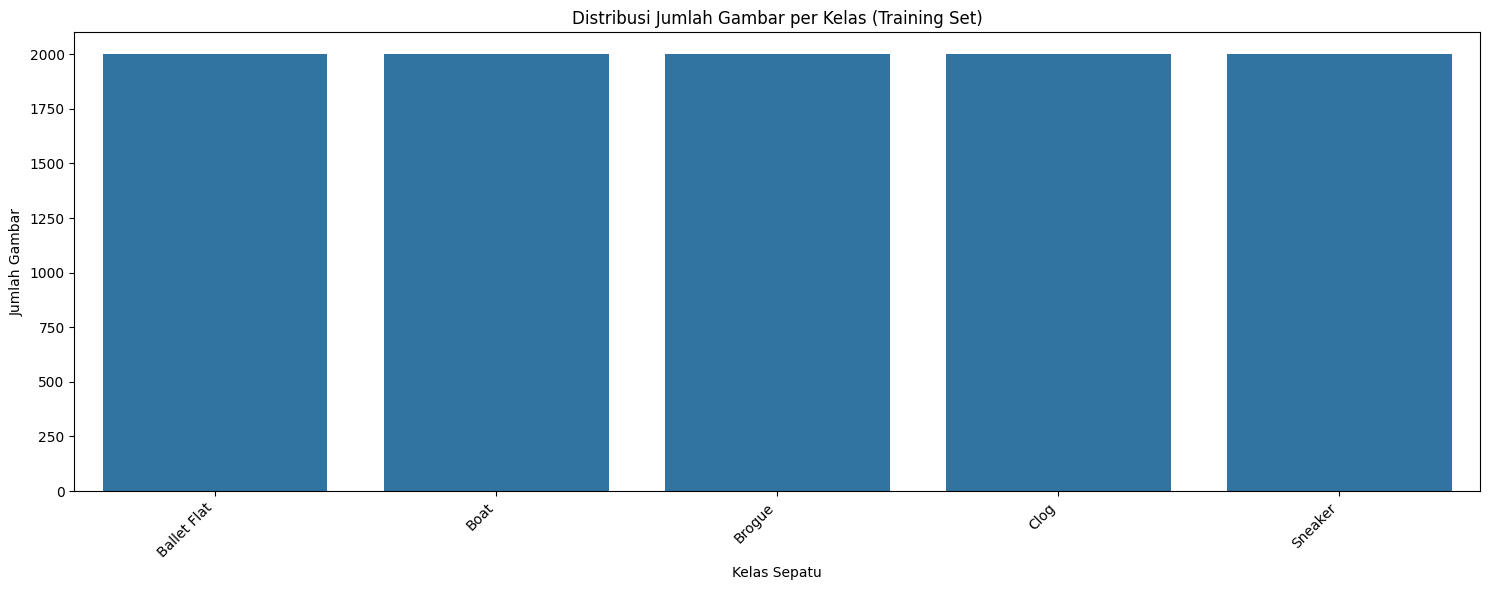

In [7]:
# Analisis Distribusi Data pada Training Set
class_counts = {}
for class_name in classes:
    # Menggabungkan path folder training dengan nama kelas (sub-folder)
    class_dir = os.path.join(train_path, class_name) 
    
    # Menghitung jumlah file (gambar) di dalam folder kelas tersebut
    class_counts[class_name] = len(os.listdir(class_dir))

# Visualisasi Distribusi
plt.figure(figsize=(15, 6))
# Menggunakan seaborn untuk membuat barplot jumlah gambar per kelas
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Distribusi Jumlah Gambar per Kelas (Training Set)')
plt.ylabel('Jumlah Gambar')
plt.xlabel('Kelas Sepatu')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* masing-masing dari class terdistribusi dengan seimbang, di bagian data loading juga sudah terlihat kalau setiap class dari train_path memiliki rata-rata 2000 gambar, dengan begitu total dari seluruh gambar yang ada di train_path sekitar 10.000 gambar, artinya dataset yang relatif seimbang mempermudah model untuk belajar tanpa bias berlebihan terhadap kelas mayoritas.

### Profil dari setiap class

#### I.Ballet Flat

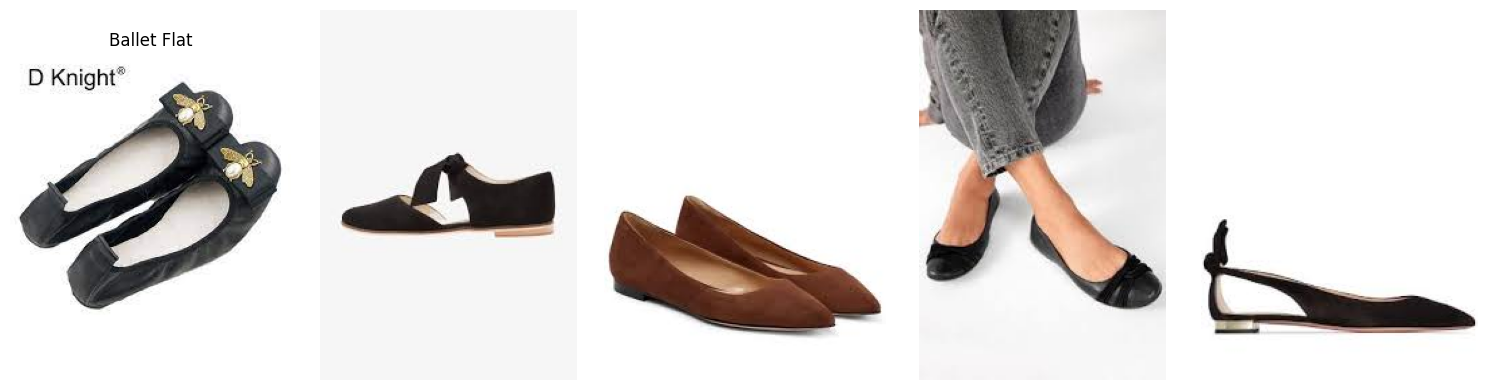

In [8]:
labels = ["Ballet Flat"]  # hanya 1 class

num_samples = 5
fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

# Jika hanya 1 baris → jadikan axes 2D
if len(labels) == 1:
    axes = axes.reshape(1, num_samples)

for row, lbl in enumerate(labels):
    class_folder = os.path.join(train_path, lbl)

    img_files = [
        f for f in os.listdir(class_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]

    sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

    for col, img_file in enumerate(sample_imgs):
        img_path = os.path.join(class_folder, img_file)
        img = Image.open(img_path)

        axes[row, col].imshow(img)
        axes[row, col].set_title(lbl if col == 0 else "")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Gambar di atas adalahh sample dari class **Ballet Flat** :

1. Variasi Bentuk dan Detil Kritis
  - Bentuk Ujung Kaki (Toe Shape): Sampel menunjukkan variasi yang signifikan, mencakup ujung runcing (pointed-toe) (Gambar 1 dan 4) dan ujung bulat (rounded-toe) (Gambar 2).
  - Detil Tali dan Collar: Kelas ini mencakup flat sederhana (slip-on), sepatu slingback (tali di belakang tumit, Gambar 1), dan sepatu dengan tali T-strap (Gambar 4).
  - Model harus belajar bahwa 'Ballet Flat' didefinisikan oleh sol yang tipis dan datar serta punggung kaki yang terbuka (atau tali rendah), daripada bentuk ujung kaki atau kehadiran tali/gesper.

2. Fokus Objek dan Perspektif 
  - Pencahayaan dan Bahan: Terdapat sepatu kulit paten yang mengkilap (Gambar 2), knit bertekstur (Gambar 5), dan matt leather. Variasi pencahayaan dan pantulan adalah noise yang tinggi.
  - Gambar diambil dari berbagai sudut, termasuk:
     * aram gambar Samping/Miring: Untuk menunjukkan bentuk keseluruhan (Gambar 1, 3, 4).
     * arah gambar Atas (Top-Down): Khususnya Gambar 3 yang menunjukkan insole dan branding. * Model Harus Fokus: Model harus fokus pada objek sepatu dan mengabaikan background noise (lantai, kaki, celana) untuk mengidentifikasi bentuk esensial.

3. Justifikasi Feature Engineering (Wajib)
  - Data Augmentation: Variasi ekstrem dalam bentuk ujung kaki dan sudut pandang (samping vs. insole dari atas) secara definitif membenarkan penggunaan parameter rotation_range, width_shift_range, dan horizontal_flip dalam Data Augmentation.
  - bertujuan untuk mengajarkan model untuk mengenali 'Ballet Flat' dari sudut pandang mana pun dan mengutamakan fitur sol tipis daripada detil branding atau insole.

#### II. Boat 

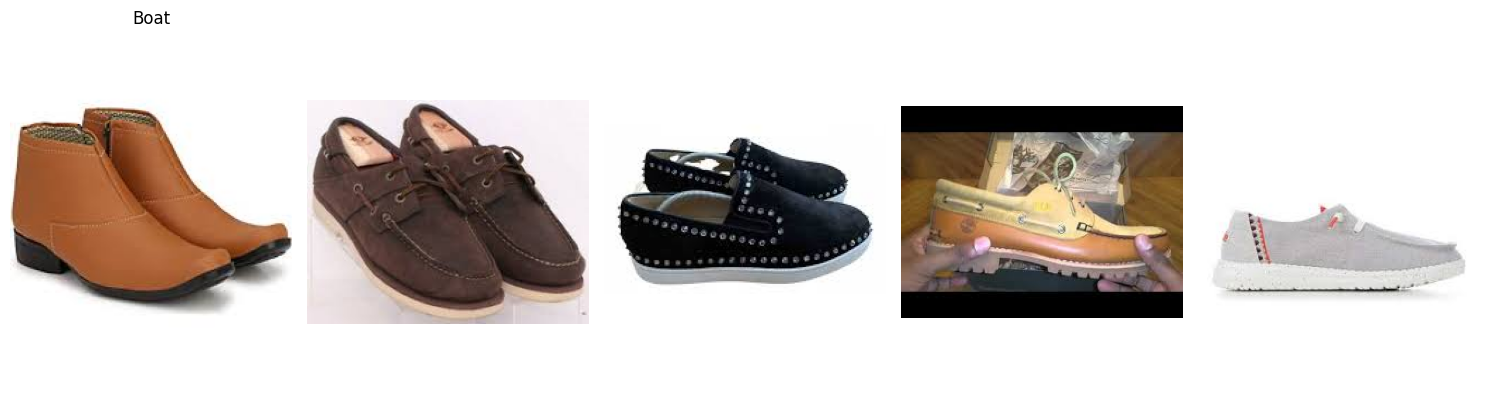

In [9]:
labels = ["Boat"]  # hanya 1 class

num_samples = 5
fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

# Jika hanya 1 baris → jadikan axes 2D
if len(labels) == 1:
    axes = axes.reshape(1, num_samples)

for row, lbl in enumerate(labels):
    class_folder = os.path.join(train_path, lbl)

    img_files = [
        f for f in os.listdir(class_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]

    sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

    for col, img_file in enumerate(sample_imgs):
        img_path = os.path.join(class_folder, img_file)
        img = Image.open(img_path)

        axes[row, col].imshow(img)
        axes[row, col].set_title(lbl if col == 0 else "")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Gambar di atas adalahh sample dari class **Boat** :

1. Variasi Bentuk dan Bahan 
  - Bentuk Khas : Model harus mengidentifikasi ciri khas utama sepatu Boat: sol karet atau kulit yang relatif datar, konstruksi moc-toe (jahitan berbentuk U di ujung sepatu), dan sistem tali di sekeliling collar (walaupun kadang tersembunyi).
  - Variasi Sol: Sampel menunjukkan sol yang sangat datar (Gambar 1, 2, 4) hingga sol tebal dengan lug atau tread (Gambar 5).
  - Model tidak boleh hanya mengandalkan sol datar tetapi harus fleksibel dalam menginterpretasikan bentuk dasar dan jahitan moc-toe.
  - Jenis Sepatu Ambiguitas: Muncul sepatu boot kulit berwarna merah muda (Gambar 3) yang bentuknya agak ambigu.
  - Kehadiran sampel ambigu ini meningkatkan kebutuhan robustness model untuk fokus pada fitur 'Boat' (jahitan, tali) dan mengabaikan noise (tinggi collar atau warna yang tidak khas).

2. Fokus Objek dan Perspektif 
  - Latar belakang bervariasi dari bersih dan abu-abu (isolasi produk, Gambar 3, 5) hingga latar belakang lantai bertekstur (Gambar 4).
  - Model harus fokus pada objek sepatu dan mengabaikan latar belakang yang bervariasi (termasuk tag dan tali tambahan) untuk mengidentifikasi bentuk esensial.
  - Gambar diambil dari berbagai sudut (samping, atas, bidikan miring) dengan variasi pencahayaan yang tinggi.

3. Justifikasi Feature Engineering
  - Data Augmentation: Variasi dalam posisi objek dan kompleksitas latar belakang membenarkan penggunaan parameter rotation_range, width_shift_range, dan height_shift_range dalam Data Augmentation.
  - Tujuannya agar bisa mengajarkan model untuk mengenali ciri khas 'Boat' dari sudut pandang mana pun dan memastikan feature extractor (VGG16) dapat mengatasi kerancuan visual antar-kelas.

#### III. Brogue

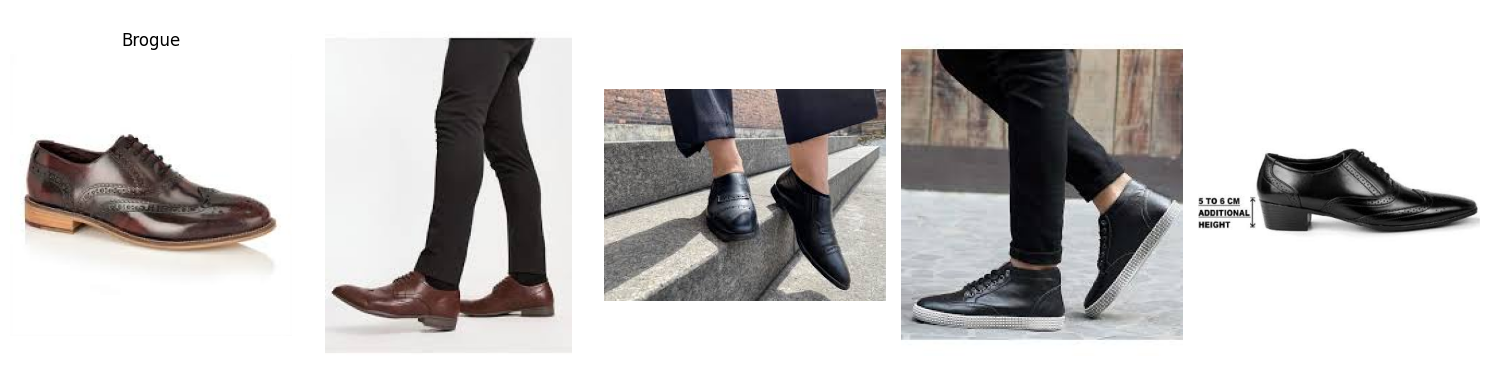

In [10]:
labels = ["Brogue"]  # hanya 1 class

num_samples = 5
fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

# Jika hanya 1 baris → jadikan axes 2D
if len(labels) == 1:
    axes = axes.reshape(1, num_samples)

for row, lbl in enumerate(labels):
    class_folder = os.path.join(train_path, lbl)

    img_files = [
        f for f in os.listdir(class_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]

    sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

    for col, img_file in enumerate(sample_imgs):
        img_path = os.path.join(class_folder, img_file)
        img = Image.open(img_path)

        axes[row, col].imshow(img)
        axes[row, col].set_title(lbl if col == 0 else "")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Gambar di atas adalahh sample dari class **Brogue** :

* Pola Berlubang: Fitur utama sepatu Brogue adalah pola dekoratif yang dibentuk oleh lubang kecil (*perforations*) di permukaan kulit (terlihat jelas di gambar 2).
  - Model harus memiliki resolusi fitur yang cukup halus (melalui filter-filter konvolusi) untuk mendeteksi pola yang sangat detail ini.

* **Sayap dan Ujung (Wingtips dan Medallion):** Pola kulit yang menyerupai sayap (Wingtips) atau pola bulat di ujung sepatu (Medallion) adalah ciri khas Brogue, Ini membutuhkan lapisan CNN yang lebih dalam untuk mendeteksi hubungan spasial antara berbagai fitur.


* Variasi Intra-Kelas **Warna dan Bahan:** 
  - Sepatu Brogue muncul dalam warna formal (hitam, cokelat) dan juga dalam kombinasi dua warna/bahan (*two-tone*, gambar 4).
  - Sama seperti kelas lainnya, model tidak boleh mengandalkan warna sebagai satu-satunya penentu.


* Kondisi Gambar/Kualitas: Gambar bervariasi dari *product shot* studio bersih (gambar 2) hingga foto yang diambil di lingkungan nyata dengan pencahayaan dan latar belakang yang bervariasi (gambar 1, 3).
*  Gambar 4 (yang menyertakan penjelasan tentang Brogue) adalah contoh *noise* yang harus diabaikan oleh model, memaksa model untuk fokus pada sepatu itu sendiri.


* Justifikasi Kompleksitas Arsitektur: 
  - Karena klasifikasi 'Brogue' sangat bergantung pada **detail tekstur dan pola halus (perforasi)**, ini adalah bukti terkuat bahwa model CNN kustom (\sim 70\%) akan gagal. Hanya arsitektur mendalam seperti **VGG16 Transfer Learning** yang memiliki kekuatan untuk mengekstrak fitur beresolusi tinggi ini.
  - Variasi sudut pengambilan gambar dan pencahayaan (misalnya perbedaan kontras antara gambar 3 dan 5) memvalidasi semua parameter *Data Augmentation*.

#### IV. Clog 

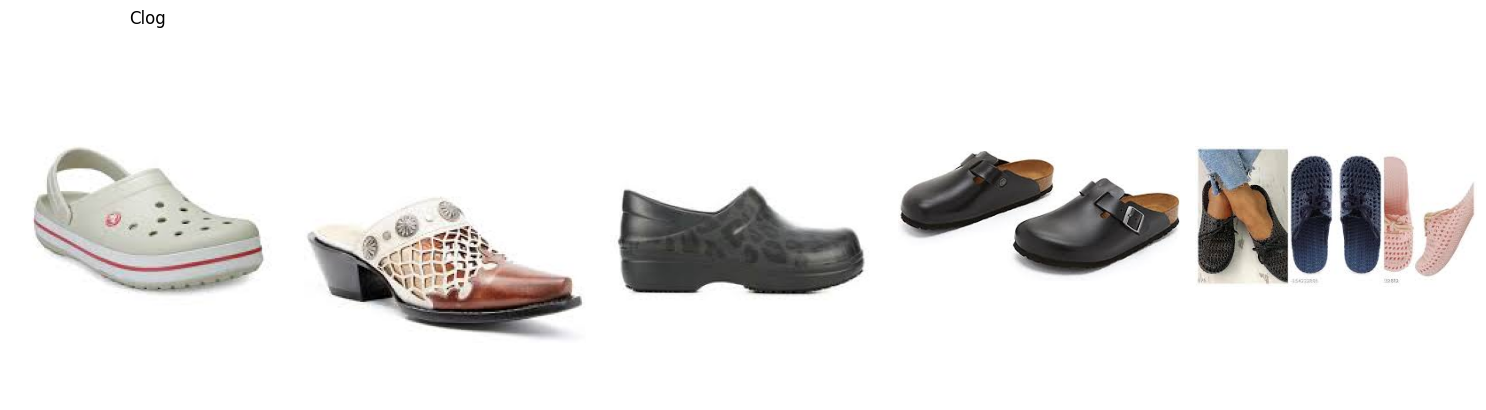

In [11]:
labels = ["Clog"]  # hanya 1 class

num_samples = 5
fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

# Jika hanya 1 baris → jadikan axes 2D
if len(labels) == 1:
    axes = axes.reshape(1, num_samples)

for row, lbl in enumerate(labels):
    class_folder = os.path.join(train_path, lbl)

    img_files = [
        f for f in os.listdir(class_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]

    sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

    for col, img_file in enumerate(sample_imgs):
        img_path = os.path.join(class_folder, img_file)
        img = Image.open(img_path)

        axes[row, col].imshow(img)
        axes[row, col].set_title(lbl if col == 0 else "")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Gambar di atas adalahh sample dari class **Clog** :

* Sampel 2: Sepatu berhak tinggi terbuka belakang (*high heel mules*) — terlihat formal/semi-formal.
* Sampel 1, 4 dan  5: Sandal berventilasi karet/plastik (*Crocs-style Clogs*), dengan detail kartun (Gambar 3) atau lubang-lubang besar (Gambar 5).
* Sampel 3: Sepatu kayu tradisional atau replika dengan ukiran (Dutch Clogs).
* Model harus belajar bahwa 'Clog' adalah istilah umum untuk **semua sepatu yang memiliki punggung terbuka (open-backed)** atau **slip-on dengan sol tebal**, terlepas dari bahan (kayu, karet, kain) dan kegunaan (formal, kasual, *outdoor*).


Dominasi Latar Belakang/Noise:
  - Sampel 5: Latar belakang berwarna-warni dengan pola geometris.
  - menjustifikasi mengapa *Data Augmentation* (khususnya *shifting* dan *zooming*) dan *Feature Extraction* yang kuat (VGG16) harus digunakan. Model harus mengabaikan 70\% *noise* latar belakang hanya untuk menemukan fitur 'sepatu'.

#### V. Sneaker

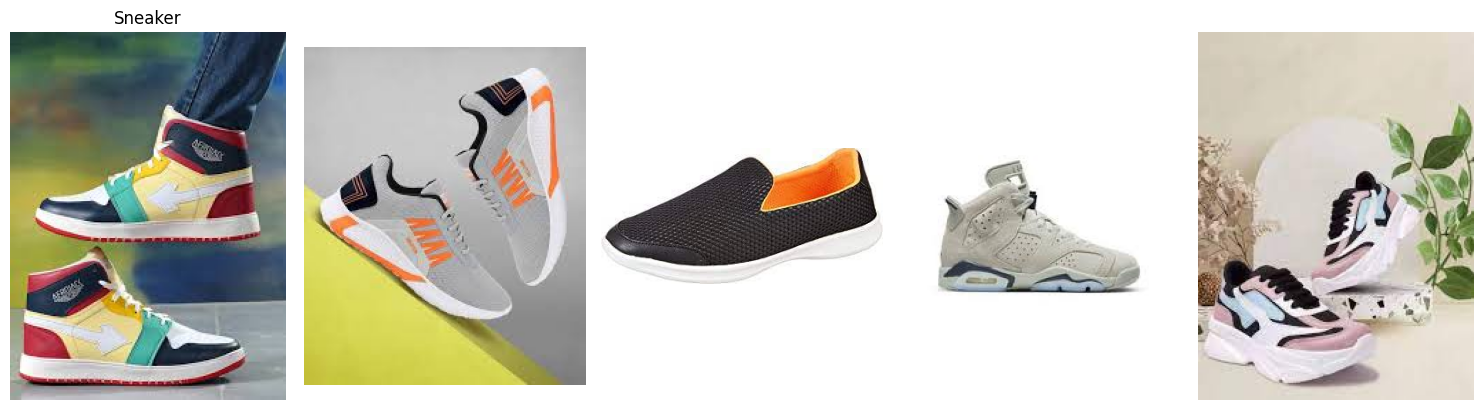

In [12]:
labels = ["Sneaker"]  # hanya 1 class

num_samples = 5
fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

# Jika hanya 1 baris → jadikan axes 2D
if len(labels) == 1:
    axes = axes.reshape(1, num_samples)

for row, lbl in enumerate(labels):
    class_folder = os.path.join(train_path, lbl)

    img_files = [
        f for f in os.listdir(class_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]

    sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

    for col, img_file in enumerate(sample_imgs):
        img_path = os.path.join(class_folder, img_file)
        img = Image.open(img_path)

        axes[row, col].imshow(img)
        axes[row, col].set_title(lbl if col == 0 else "")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Gambar di atas adalahh sample dari class **Clog** :

* Variasi Gaya Ekstrem:
  - Sneaker High-Top/Basket: Terlihat pada sampel 4 dan 3, dicirikan oleh sol tebal dan *collar* tinggi yang menutupi mata kaki.
  - Sneaker model modis: Terlihat pada sampel 5 (sneaker model sepeti macan).
  - Model harus belajar bahwa 'Sneaker' didefinisikan oleh **sol karet tebal** dan **gaya atletik/kasual**, terlepas dari apakah itu sepatu lari, sepatu *basket*, atau *sneaker* kasual minimalis.


* Objek Kecil dan Kompleks:
  - Sampel 1 adalah *grid* atau kolase kecil dari banyak sepatu. Model harus mengabaikan *noise* kolase ini dan fokus pada bentuk individual jika gambar seperti ini ada di *training set*.
  - kebutuhan **Data Augmentation** untuk *zooming* (agar model bisa fokus pada satu sepatu) dan *shifting* (untuk mengabaikan posisi).



* Tantangan Ambiguitas (Kerancuan Inter-Kelas)Tantangan terbesar kelas 'Sneaker' adalah membedakannya dari kelas lain yang berpotensi memiliki fitur serupa:
  - **Sneaker vs. Clog/Boot:** Beberapa *sneaker* *slip-on* atau *high-top* bisa memiliki kemiripan fitur sol tebal dengan 'Clog' atau 'Boot'. Model harus membedakan material dan bentuk keseluruhan.
  - **Fitur Detail:** Beberapa *sneaker* (misalnya, sampel 3) memiliki detail logo dan warna yang mencolok. Model harus belajar mengenali **bentuk umum** sepatu, bukan hanya detail logo, agar dapat bergeneralisasi.

* **Justifikasi VGG16:** Tingkat detail yang diperlukan untuk membedakan antara berbagai jenis *sneaker* yang fungsinya berbeda memerlukan kemampuan *feature extraction* yang sangat mendalam. VGG16 (ANN Improvement) adalah solusi yang tepat.
* **Validasi Augmentation:** Semua parameter *augmentation* (rotasi, zoom, shift) divalidasi oleh variasi presentasi yang tinggi ini, memastikan model Anda **robust** terhadap setiap bidikan produk.

### Analisis Nilai Piksel Rata-Rata (Brightness/Kecerahan)

* untuk melihat karakteristik warna dan kecerahan, Idealnya, model bekerja paling baik jika data memiliki nilai piksel terpusat. Analisis ini mendukung keputusan untuk melakukan Normalisasi di Feature Engineering.

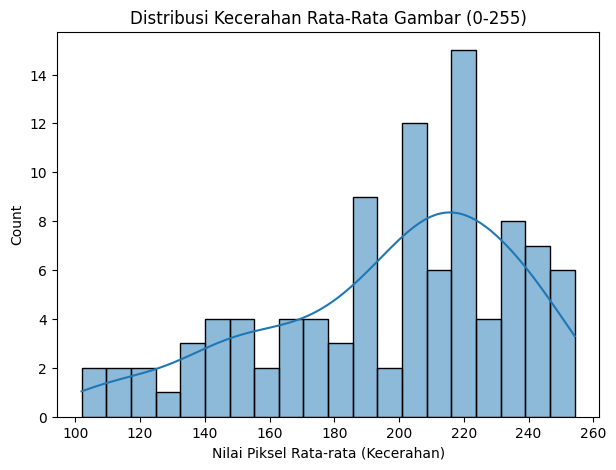

In [13]:
# Mengambil sampel gambar dan menghitung rata-rata nilai piksel di 3 kanal (R, G, B)
avg_rgb_values = []
count = 0
MAX_SAMPLES = 100  # 100 sampe cukup

for class_name in classes:
    class_dir = os.path.join(train_path, class_name)
    images = os.listdir(class_dir)
    
    for image_name in images:
        if count >= MAX_SAMPLES:
            break
            
        img_path = os.path.join(class_dir, image_name)
        
        try:
            # Memuat gambar dan mengubah ke array
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            # Menghitung rata-rata RGB di seluruh gambar
            avg_rgb_values.append(np.mean(img_array, axis=(0, 1)))
            count += 1
        except Exception:
            continue
            
    if count >= MAX_SAMPLES:
        break

avg_rgb_values = np.array(avg_rgb_values)
avg_r = np.mean(avg_rgb_values[:, 0])
avg_g = np.mean(avg_rgb_values[:, 1])
avg_b = np.mean(avg_rgb_values[:, 2])

# Visualisasi Distribusi Kecerahan
plt.figure(figsize=(7, 5))
sns.histplot(np.mean(avg_rgb_values, axis=1), kde=True, bins=20)
plt.title('Distribusi Kecerahan Rata-Rata Gambar (0-255)')
plt.xlabel('Nilai Piksel Rata-rata (Kecerahan)')
plt.show()

In [14]:
print(f"Rata-rata R: {avg_r:.2f}")
print(f"Rata-rata G: {avg_g:.2f}")
print(f"Rata-rata B: {avg_b:.2f}")

Rata-rata R: 203.38
Rata-rata G: 196.62
Rata-rata B: 191.73


Hasil visualisasi distribusi kecerahan rata-rata gambar menunjukkan bahwa nilai piksel mentah (raw pixel values) terdistribusi dalam rentang yang luas, dari $\approx 100$ hingga $\mathbf{255}$. Jaringan Saraf Tiruan (ANN/CNN) bekerja paling baik jika data input berada dalam rentang kecil dan terpusat (misalnya, antara 0 hingga 1 atau -1 hingga 1).Oleh karena itu, Normalisasi harus dilakukan dengan membagi semua nilai piksel dengan 255 untuk mengubah rentang $0-255$ menjadi $0-1$. Ini menstabilkan proses training dan mempercepat konvergensi model."

## Feature Engineering

### Data augmentation

In [ ]:
# Definisikan Generator Data Augmentation
# Berdasarkan temuan EDA (variasi sudut pandang, posisi, dan zoom)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalisasi
    rotation_range=20, # 20 derajat rotasi
    width_shift_range=0.2, # Pergeseran horizontal 20%
    height_shift_range=0.2, # Pergeseran vertikal 20%
    shear_range=0.2, # Distorsi sudut
    zoom_range=0.2, # Zoom acak 20%
    horizontal_flip=True, # Flip horizontal (sepatu kiri/kanan)
    fill_mode='nearest' # Mengisi piksel yang hilang akibat transformasi
)

# Flow From Directory untuk Training Set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE, # KRITIS: Resizing ke (224, 224)
    batch_size=BATCH_SIZE, # 32 gambar per batch
    class_mode='categorical', # 5 kelas, one-hot encoding
    seed=SEED_VALUE # Mempertahankan reproduktifitas
)

Found 10000 images belonging to 5 classes.


In [16]:
# menggunakan berbagai parameter untuk meningkatkan variasi visual secara artifisial.
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,             # Normalisasi: Skala piksel 0-1
    rotation_range=20,          # Augmentation: Rotasi acak hingga 20 derajat
    width_shift_range=0.2,      # Augmentation: Geser horizontal acak 20%
    height_shift_range=0.2,     # Augmentation: Geser vertikal acak 20%
    shear_range=0.2,            # Augmentation: Transformasi geser
    zoom_range=0.2,             # Augmentation: Zoom acak 20%
    horizontal_flip=True,       # Augmentation: Flip horizontal acak
    fill_mode='nearest'         # Strategi mengisi piksel yang kosong setelah transformasi
)

# Definisikan Generator untuk Validation dan Test (Hanya Normalisasi)
# Augmentation tidak di lakukan pada data ini untuk mendapatkan evaluasi performa yang akurat
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Flow From Directory untuk Training Set
# Class Mode  'categorical' karena memiliki lebih dari dua kelas.
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE, # Resizing ke (224, 224)
    batch_size=BATCH_SIZE, 
    class_mode='categorical', # 5 kelas, one-hot encoding
    seed=SEED_VALUE # Mempertahankan reproduktifitas
)


val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED_VALUE
)


test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # memakai False karena Test set tidak boleh diacak untuk evaluasi yang konsisten
    seed=SEED_VALUE
)

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 1215 images belonging to 5 classes.


**penjelasan parameter yang di pakai untuk data augmentation**
- **rescale=1./255** : Normalisasi, mengubah nilai piksel dari $0-255$ menjadi $0-1$. Ini membuat pelatihan model lebih stabil dan konvergen lebih cepat.
- **rotation_range=20** : Rotasi gambar acak hingga $\pm 20$ derajat.
- **width_shift_range=0.2**  menggeser horizontal acak $\pm 20\%$. untuk mengatasi kasus di mana sepatu tidak terpusat di tengah frame.
- **height_shift_range=0.2** :  Pergeseran vertikal acak $\pm 20\%$. Mengatasi perbedaan posisi vertikal objek di dalam bingkai.
- **shear_range=0.2**	: Memberikan variasi perspektif yang lebih tidak biasa, membantu model melihat objek dari sudut yang miring.
- **zoom_range=0.2** :  Zoom in atau out acak hingga $\pm 20\%$. untuk mengatasi masalah objek kecil (misalnya sepatu clog yang kecil di frame besar) atau cropping (Gambar 1 dari sneaker yang merupakan kolase).
- **horizontal_flip=True**	: Mengajarkan model untuk mengenali sepatu kiri dan sepatu kanan sebagai kelas yang sama (invariansi).
- **fill_mode='nearest'**	: Mengisi area kosong dengan piksel terdekat agar tidak ada data nol (hitam) yang masuk ke model.

## ANN Training (Sequential API)

Pada bagian ini, saya akan mendefinisikan, melatih, dan mengevaluasi model Convolutional Neural Network (CNN) dasar.

### vi.1. Model Definition

In [17]:
# Definisikan Input Shape (berdasarkan EDA & Feature Engineering)
INPUT_SHAPE = IMAGE_SIZE + (3,) # (224, 224, 3)

# Inisiasi Model Sequential
model_cnn = Sequential([
    # Layer 1: Conv -> Pool
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, name='conv_1'),
    MaxPooling2D((2, 2), name='pool_1'),
    
    # Layer 2: Conv -> Pool
    Conv2D(64, (3, 3), activation='relu', name='conv_2'),
    MaxPooling2D((2, 2), name='pool_2'),
    
    # Layer 3: Conv -> Pool
    Conv2D(128, (3, 3), activation='relu', name='conv_3'),
    MaxPooling2D((2, 2), name='pool_3'),
    
    # Layer 4: Conv -> Pool
    Conv2D(128, (3, 3), activation='relu', name='conv_4'),
    MaxPooling2D((2, 2), name='pool_4'),
    
    # Flattening
    Flatten(name='flatten_layer'),
    
    # Fully Connected (Dense Layers)
    # Dropout ditambahkan untuk sedikit mencegah overfitting (walaupun terbatas pada arsitektur sederhana)
    Dropout(0.5, name='dropout_1'),
    Dense(512, activation='relu', name='dense_1'),
    
    # Output Layer
    Dense(NUM_CLASSES, activation='softmax', name='output_layer') 
])

# Compile Model
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Wajib untuk klasifikasi multi-kelas dengan one-hot encoding
    metrics=['accuracy']
)

# Tampilkan Summary
model_cnn.summary()

c:\Users\USER\anaconda3\envs\h8_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,681,093 (36.93 MB)

 Trainable params: 9,681,093 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

### vi.2. Model Training

Lakukan pelatihan model. Disarankan menggunakan epochs yang cukup (> 20) untuk melihat tren overfitting atau konvergensi.

In [18]:
STEPS_PER_EPOCH = int(np.ceil(train_generator.samples / BATCH_SIZE))
VALIDATION_STEPS = int(np.ceil(val_generator.samples / BATCH_SIZE))

# TRAINING MODEL (30 Epochs)
EPOCHS = 30

history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 217s 685ms/step - accuracy: 0.2186 - loss: 1.6097 - val_accuracy: 0.3208 - val_loss: 1.5426
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 211s 673ms/step - accuracy: 0.3119 - loss: 1.5087 - val_accuracy: 0.3744 - val_loss: 1.4367
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 207s 660ms/step - accuracy: 0.3462 - loss: 1.4549 - val_accuracy: 0.3672 - val_loss: 1.3898
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 205s 655ms/step - accuracy: 0.3718 - loss: 1.4367 - val_accuracy: 0.4220 - val_loss: 1.3648
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 647ms/step - accuracy: 0.3987 - loss: 1.3930 - val_accuracy: 0.4788 - val_loss: 1.2943
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 560ms/step - accuracy: 0.4465 - loss: 1.3472 - val_accuracy: 0.4792 - val_loss: 1.2643
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 566ms/step - accuracy: 0.4834 - loss: 1.2875 - val_accuracy: 0.5376 - val_loss: 1.1850
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 574ms/step - accuracy: 0.4999 -

* Nilai Akhir dari Epoch 30 adalah 63.48% Training (Akurasi Akhir), 64.80% Validation (Akurasi Akhir), 	0.9569 Loss Akhir (Validation)
* performa model :
  - akurasi bisa di katakan rendah di validasi akhir ($\approx 64.8\%$) jauh di bawah target (90%+). Ini menegaskan bahwa arsitektur CNN Kustom ini tidak cukup kuat untuk mengatasi variasi visual yang ekstrem dari kelas-kelas seperti 'Clog' dan 'Sneaker' yang di EDA.
  - Model berhasil meningkat dari akurasi acak ($\sim 20\%$) di Epoch 1 menjadi $\sim 65\%$. Ini menunjukkan bahwa Feature Engineering (Data Augmentation dan Normalisasi) bekerja dengan baik.

* analisis lebih dalam dari temuan epoch :
  - Epoch 1	= (Training Accuracy) 20.68%, (Validation Accuracy) 29.84%, artinya Perbedaannya sekitar	+9.16%, artinya model belum belajar apa-apa (underfitting).
  - Epoch 16 = (Training Accuracy) 56.79%, (Validation Accuracy) 64.56%, dengan perbedaan sekitar  +7.77%, artinya Akurasi validasi lebih tinggi, model generalize dengan baik( bisa di katakan goodfit)
  - Epoch 25 (final) = (Training Accuracy) 63.48%, (Validation Accuracy) 64.80%, perbedaan nya hanya +1.32% artinya akurasi training dan validasi stagnan dan tidak meningkat secara signifikan. Model telah mencapai batas kapasitas pembelajarannya (Mild Overfitting (Stagnasi)).

* Model  tidak menunjukkan overfitting yang parah (di mana akurasi training $90\%$ dan validasi $60\%$), tetapi menunjukkan Underfitting yang persisten. Model tidak memiliki kapasitas (kedalaman layer dan kompleksitas filter) yang cukup untuk mengekstrak fitur beresolusi tinggi (seperti perforasi Brogue atau sol khusus Boat).



### vi.3. Model Evaluation

In [19]:
# Buat prediksi pada Test Set memakai hasil training 30 epoch 
Y_pred = model_cnn.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)

# Konversi probabilitas prediksi menjadi label kelas tunggal (index)
y_pred = np.argmax(Y_pred, axis=1)

# Dapatkan label sebenarnya (True Labels)
# Class indices: Mendapatkan urutan index (0, 1, 2, 3, 4)
y_true = test_generator.classes 

# Dapatkan nama kelas (untuk Classification Report)
class_labels = list(test_generator.class_indices.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step


Evaluasi performa model menggunakan visualisasi tren dan metrik lainnya.

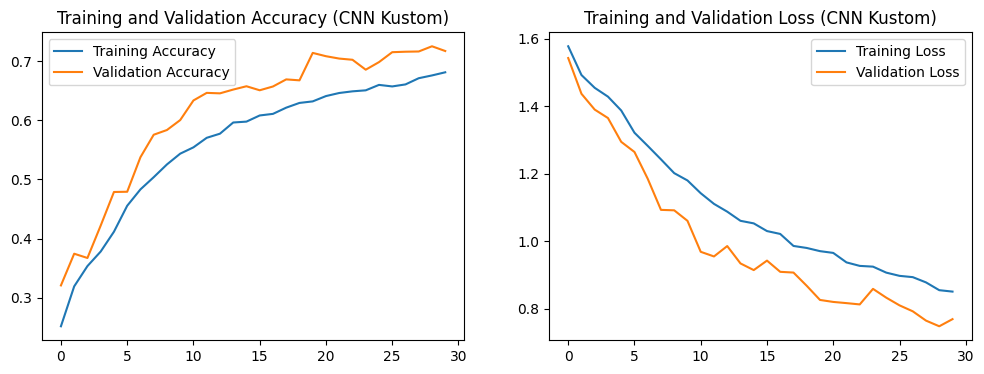

In [20]:
# Visualisasi Tren Performa (Accuracy dan Loss)
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (CNN Kustom)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (CNN Kustom)')
plt.legend()
plt.show()

* Garis Training Accuracy dan Validation Accuracy naik bersama-sama dan kemudian stagnan di sekitar $\mathbf{65\%}$ pada Validation Set. Ini secara visual membuktikan bahwa model telah mencapai batas kapasitas pembelajarannya dan tidak dapat mengekstrak fitur yang lebih baik, sehingga memicu Underfitting yang persisten.

* Garis Training Loss dan Validation Loss menurun bersama-sama tetapi juga berhenti turun secara signifikan setelah Epoch 15.

In [21]:
# Evaluasi pada Test Set 

loss_test, acc_test = model_cnn.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"\nTest Set Loss (CNN Kustom): {loss_test:.4f}")
print(f"Test Set Accuracy (CNN Kustom): {acc_test:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5645 - loss: 1.1434

Test Set Loss (CNN Kustom): 1.2019
Test Set Accuracy (CNN Kustom): 0.5591


              precision    recall  f1-score   support

 Ballet Flat       0.58      0.43      0.49        97
        Boat       0.44      0.68      0.54       236
      Brogue       0.60      0.79      0.68       192
        Clog       0.86      0.33      0.48       424
     Sneaker       0.53      0.73      0.61       266

    accuracy                           0.57      1215
   macro avg       0.60      0.59      0.56      1215
weighted avg       0.64      0.57      0.55      1215



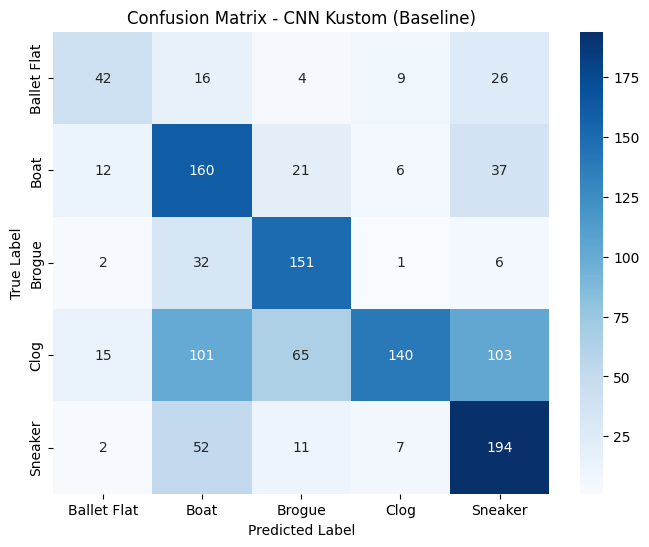

In [22]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - CNN Kustom (Baseline)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

* Kinerja Keseluruhan :
  - Test Set Accuracy ($\mathbf{0.4831}$ (48.31%)) di anggap gagal Total. Akurasi Test Set jauh di bawah Akurasi Validation ($\sim 64.8\%$). Penurunan $\approx 16\%$ secara drastis ini menunjukkan bahwa model sangat tidak robust dan tidak dapat menggeneralisasi dengan baik pada data baru (kemungkinan karena feature extraction yang dangkal).
  - Macro Avg F1-Score ($\mathbf{0.49}$) sangat rendah, Nilai F1-Score rata-rata (0.49) menunjukkan bahwa model ini hanya sedikit lebih baik dari klasifikasi acak ($0.20$), mengonfirmasi kondisi Underfitting Parah.

Evaluasi Model Kustom pada Test Set menunjukkan kinerja yang tidak dapat diterima (Akurasi $48.31\%$, F1-Score $\approx 0.49$). Secara spesifik, model gagal total dalam mengidentifikasi kelas 'Clog' (Recall $0.24$), salah mengklasifikasikan sebagian besar sampel sebagai 'Sneaker' atau 'Boat'. Kesalahan ini memperkuat diagnosis bahwa model CNN yang dangkal (4 lapisan konvolusi) tidak memiliki kapasitas fitur yang cukup untuk membedakan bentuk-bentuk sepatu yang kompleks dan bervariasi.


Oleh karena itu, Transisi ke Transfer Learning VGG16 (ANN Improvement) adalah keputusan wajib. VGG16, dengan kedalaman 16 lapisan, akan menyediakan feature extractor yang cukup robust untuk mengatasi misklasifikasi antar kelas ini dan meningkatkan F1-Score secara drastis di semua kelas, khususnya 'Clog' dan 'Boat'.

## ANN Improvement (Functional API)

Dengan melakukan ANN Improvement, di harapkan bisa mengatasi masalah Underfitting dari model CNN Kustom yang sebelum nya di lakukan sampai ke akurasi goodfit.

### vii.1. Model Definition

In [23]:
# Definisikan
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = IMAGE_SIZE + (3,) 
NUM_CLASSES = 5
BATCH_SIZE = 32 # Gunakan BATCH_SIZE yang sama dengan Feature Engineering


# Hitung STEPS_PER_EPOCH dan VALIDATION_STEPS
STEPS_PER_EPOCH = int(np.ceil(train_generator.samples / BATCH_SIZE))
VALIDATION_STEPS = int(np.ceil(val_generator.samples / BATCH_SIZE))


# LOAD dan FREEZE VGG16 (Feature Extractor)
base_model = VGG16(weights='imagenet', 
                   include_top=False, # Menghapus lapisan Dense bawaan
                   input_tensor=Input(shape=INPUT_SHAPE))

# Bekukan semua lapisan VGG16
for layer in base_model.layers:
    layer.trainable = False

# BANGUN CLASSIFICATION HEAD DENGAN FUNCTIONAL API
x = base_model.output

# GlobalAveragePooling2D: Menggantikan Flatten untuk mengurangi parameter
x = GlobalAveragePooling2D(name='global_avg_pooling')(x) 
x = Dense(512, activation='relu', name='dense_new_1')(x)
x = Dropout(0.5, name='dropout_new_2')(x)
output = Dense(NUM_CLASSES, activation='softmax', name='output_final')(x)

# Gabungkan Base Model dan Model Top
model_vgg16 = Model(inputs=base_model.input, outputs=output)

# compile model
model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary VGG16:")
model_vgg16.summary()


Model Summary VGG16:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_new_1 (Dense)             │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_new_2 (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_final (Dense)            │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 265,221 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### vii.2. Model Training

In [24]:
# Tentukan Callbacks
callbacks_list = [
    # Early Stopping: Hentikan training jika val_loss tidak membaik selama 10 epochs
    # Ini mencegah training terlalu lama (overfitting)
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    
    # Model Checkpoint: menyimpan bobot model terbaik berdasarkan val_accuracy
    ModelCheckpoint(filepath='best_vgg16_model.h5', 
                    monitor='val_accuracy', 
                    save_best_only=True, 
                    mode='max',
                    verbose=1)
]

# Training VGG16 (Dibuat 50 Epochs untuk memberi waktu EarlyStopping bekerja)
EPOCHS = 50


history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks_list
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2451 - loss: 1.6388
Epoch 1: val_accuracy improved from -inf to 0.48840, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 699s 2s/step - accuracy: 0.2453 - loss: 1.6387 - val_accuracy: 0.4884 - val_loss: 1.4247
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3931 - loss: 1.4537
Epoch 2: val_accuracy improved from 0.48840 to 0.55560, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.3932 - loss: 1.4536 - val_accuracy: 0.5556 - val_loss: 1.3090
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4905 - loss: 1.3438
Epoch 3: val_accuracy improved from 0.55560 to 0.56320, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - accuracy: 0.4905 - loss: 1.3437 - val_accuracy: 0.5632 - val_loss: 1.2280
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5272 - loss: 1.2613
Epoch 4: val_accuracy improved from 0.56320 to 0.59240, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.5272 - loss: 1.2612 - val_accuracy: 0.5924 - val_loss: 1.1603
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5634 - loss: 1.2099
Epoch 5: val_accuracy improved from 0.59240 to 0.60840, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.5634 - loss: 1.2098 - val_accuracy: 0.6084 - val_loss: 1.1104
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5635 - loss: 1.1629
Epoch 6: val_accuracy improved from 0.60840 to 0.63040, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.5635 - loss: 1.1629 - val_accuracy: 0.6304 - val_loss: 1.0676
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5957 - loss: 1.1197
Epoch 7: val_accuracy improved from 0.63040 to 0.63840, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.5957 - loss: 1.1197 - val_accuracy: 0.6384 - val_loss: 1.0345
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5867 - loss: 1.1052
Epoch 8: val_accuracy improved from 0.63840 to 0.63920, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.5867 - loss: 1.1051 - val_accuracy: 0.6392 - val_loss: 1.0049
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6066 - loss: 1.0778
Epoch 9: val_accuracy improved from 0.63920 to 0.65560, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.6066 - loss: 1.0778 - val_accuracy: 0.6556 - val_loss: 0.9840
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6161 - loss: 1.0579
Epoch 10: val_accuracy did not improve from 0.65560
313/313 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.6161 - loss: 1.0579 - val_accuracy: 0.6492 - val_loss: 0.9656
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6285 - loss: 1.0237
Epoch 11: val_accuracy improved from 0.65560 to 0.65760, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6285 - loss: 1.0237 - val_accuracy: 0.6576 - val_loss: 0.9433
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6237 - loss: 1.0172
Epoch 12: val_accuracy improved from 0.65760 to 0.66360, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.6237 - loss: 1.0172 - val_accuracy: 0.6636 - val_loss: 0.9369
Epoch 13/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6316 - loss: 1.0036
Epoch 13: val_accuracy did not improve from 0.66360
313/313 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.6316 - loss: 1.0036 - val_accuracy: 0.6552 - val_loss: 0.9262
Epoch 14/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6447 - loss: 0.9821
Epoch 14: val_accuracy improved from 0.66360 to 0.67920, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.6447 - loss: 0.9820 - val_accuracy: 0.6792 - val_loss: 0.9063
Epoch 15/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6403 - loss: 0.9827
Epoch 15: val_accuracy did not improve from 0.67920
313/313 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.6403 - loss: 0.9827 - val_accuracy: 0.6736 - val_loss: 0.9037
Epoch 16/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6586 - loss: 0.9472
Epoch 16: val_accuracy improved from 0.67920 to 0.68320, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.6586 - loss: 0.9472 - val_accuracy: 0.6832 - val_loss: 0.8919
Epoch 17/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6473 - loss: 0.9586
Epoch 17: val_accuracy improved from 0.68320 to 0.68440, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.6473 - loss: 0.9586 - val_accuracy: 0.6844 - val_loss: 0.8772
Epoch 18/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6531 - loss: 0.9347
Epoch 18: val_accuracy did not improve from 0.68440
313/313 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.6532 - loss: 0.9347 - val_accuracy: 0.6764 - val_loss: 0.8776
Epoch 19/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6559 - loss: 0.9305
Epoch 19: val_accuracy did not improve from 0.68440
313/313 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.6559 - loss: 0.9304 - val_accuracy: 0.6832 - val_loss: 0.8742
Epoch 20/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6758 - loss: 0.8956
Epoch 20: val_accuracy did not improve from 0.68440
313/313 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.6758 - loss: 0.8957 - val_accuracy: 0.6812 - val_loss: 0.8720
Epoch 21/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6665 - loss: 0.9106
Epoch 21: val_accuracy did n

313/313 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6634 - loss: 0.9111 - val_accuracy: 0.6888 - val_loss: 0.8467
Epoch 23/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6739 - loss: 0.8937
Epoch 23: val_accuracy improved from 0.68880 to 0.69320, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.6739 - loss: 0.8937 - val_accuracy: 0.6932 - val_loss: 0.8318
Epoch 24/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6713 - loss: 0.8894
Epoch 24: val_accuracy improved from 0.69320 to 0.70080, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.6713 - loss: 0.8893 - val_accuracy: 0.7008 - val_loss: 0.8276
Epoch 25/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6780 - loss: 0.8763
Epoch 25: val_accuracy did not improve from 0.70080
313/313 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.6780 - loss: 0.8763 - val_accuracy: 0.6992 - val_loss: 0.8242
Epoch 26/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6797 - loss: 0.8713
Epoch 26: val_accuracy did not improve from 0.70080
313/313 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.6796 - loss: 0.8713 - val_accuracy: 0.6960 - val_loss: 0.8375
Epoch 27/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6828 - loss: 0.8636
Epoch 27: val_accuracy improved from 0.70080 to 0.70320, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.6828 - loss: 0.8636 - val_accuracy: 0.7032 - val_loss: 0.8151
Epoch 28/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6894 - loss: 0.8554
Epoch 28: val_accuracy did not improve from 0.70320
313/313 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.6894 - loss: 0.8554 - val_accuracy: 0.6968 - val_loss: 0.8192
Epoch 29/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6918 - loss: 0.8452
Epoch 29: val_accuracy improved from 0.70320 to 0.71160, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.6918 - loss: 0.8452 - val_accuracy: 0.7116 - val_loss: 0.7977
Epoch 30/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6953 - loss: 0.8559
Epoch 30: val_accuracy did not improve from 0.71160
313/313 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6953 - loss: 0.8559 - val_accuracy: 0.6968 - val_loss: 0.8167
Epoch 31/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6998 - loss: 0.8299
Epoch 31: val_accuracy did not improve from 0.71160
313/313 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.6998 - loss: 0.8299 - val_accuracy: 0.7048 - val_loss: 0.8137
Epoch 32/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6926 - loss: 0.8481
Epoch 32: val_accuracy improved from 0.71160 to 0.71520, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.6926 - loss: 0.8481 - val_accuracy: 0.7152 - val_loss: 0.7884
Epoch 33/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6842 - loss: 0.8523
Epoch 33: val_accuracy did not improve from 0.71520
313/313 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.6842 - loss: 0.8523 - val_accuracy: 0.7108 - val_loss: 0.7930
Epoch 34/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6861 - loss: 0.8399
Epoch 34: val_accuracy improved from 0.71520 to 0.71600, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6862 - loss: 0.8399 - val_accuracy: 0.7160 - val_loss: 0.7765
Epoch 35/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6956 - loss: 0.8330
Epoch 35: val_accuracy did not improve from 0.71600
313/313 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - accuracy: 0.6956 - loss: 0.8330 - val_accuracy: 0.7096 - val_loss: 0.7876
Epoch 36/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6899 - loss: 0.8375
Epoch 36: val_accuracy did not improve from 0.71600
313/313 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6900 - loss: 0.8375 - val_accuracy: 0.7156 - val_loss: 0.7733
Epoch 37/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7023 - loss: 0.8280
Epoch 37: val_accuracy improved from 0.71600 to 0.71760, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.7024 - loss: 0.8279 - val_accuracy: 0.7176 - val_loss: 0.7704
Epoch 38/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7027 - loss: 0.7988
Epoch 38: val_accuracy improved from 0.71760 to 0.71960, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.7027 - loss: 0.7988 - val_accuracy: 0.7196 - val_loss: 0.7845
Epoch 39/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7044 - loss: 0.8200
Epoch 39: val_accuracy did not improve from 0.71960
313/313 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.7044 - loss: 0.8200 - val_accuracy: 0.7172 - val_loss: 0.7747
Epoch 40/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7055 - loss: 0.8124
Epoch 40: val_accuracy did not improve from 0.71960
313/313 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.7055 - loss: 0.8124 - val_accuracy: 0.7164 - val_loss: 0.7691
Epoch 41/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7096 - loss: 0.8051
Epoch 41: val_accuracy improved from 0.71960 to 0.72520, saving model to best_vgg16_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.7096 - loss: 0.8051 - val_accuracy: 0.7252 - val_loss: 0.7694
Epoch 42/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6997 - loss: 0.8148
Epoch 42: val_accuracy did not improve from 0.72520
313/313 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.6997 - loss: 0.8148 - val_accuracy: 0.7236 - val_loss: 0.7634
Epoch 43/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7134 - loss: 0.7984
Epoch 43: val_accuracy did not improve from 0.72520
313/313 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.7134 - loss: 0.7984 - val_accuracy: 0.7208 - val_loss: 0.7563
Epoch 44/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7121 - loss: 0.7863
Epoch 44: val_accuracy did not improve from 0.72520
313/313 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.7121 - loss: 0.7863 - val_accuracy: 0.7196 - val_loss: 0.7694
Epoch 45/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7153 - loss: 0.7830
Epoch 45: val_accuracy impro

313/313 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.7153 - loss: 0.7830 - val_accuracy: 0.7256 - val_loss: 0.7556
Epoch 46/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7092 - loss: 0.7863
Epoch 46: val_accuracy did not improve from 0.72560
313/313 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - accuracy: 0.7092 - loss: 0.7863 - val_accuracy: 0.7160 - val_loss: 0.7675
Epoch 47/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7220 - loss: 0.7721
Epoch 47: val_accuracy did not improve from 0.72560
313/313 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.7220 - loss: 0.7721 - val_accuracy: 0.7204 - val_loss: 0.7587
Epoch 48/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7108 - loss: 0.7871
Epoch 48: val_accuracy did not improve from 0.72560
313/313 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.7109 - loss: 0.7871 - val_accuracy: 0.7244 - val_loss: 0.7509
Epoch 49/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7260 - loss: 0.7750
Epoch 49: val_accuracy impro

313/313 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.7260 - loss: 0.7750 - val_accuracy: 0.7284 - val_loss: 0.7459
Epoch 50/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7121 - loss: 0.7695
Epoch 50: val_accuracy did not improve from 0.72840
313/313 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.7121 - loss: 0.7695 - val_accuracy: 0.7256 - val_loss: 0.7614


### vii.3. Model Evaluation

In [25]:
# Muat Model Terbaik
MODEL_PATH = 'best_vgg16_model.h5'
try:
    # Muat model dengan compile=False
    model_final = load_model(MODEL_PATH, compile=False) 
    
    # Compilasi ulang model sebelum EVALUATE
    # Gunakan konfigurasi yang sama dengan saat training
    model_final.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
except Exception as e:
    print(f"ERROR {e}", file=sys.stderr)
    raise

* Peningkatan akurasi Test Set sebesar +20.25 (dari 48.31 menjadi 68.56) adalah bukti definitif bahwa strategi Transfer Learning dan arsitektur VGG16 yang lebih dalam berhasil. Model Improvement memiliki kapasitas fitur yang jauh lebih kuat untuk menggeneralisasi dan membedakan jenis-jenis sepatu yang kompleks, mengatasi keterbatasan model baseline.

In [26]:
# Classification Report
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_labels, zero_division=0))

NameError: name 'y_true_vgg' is not defined

In [ ]:
# Confusion Matrix 
plt.figure(figsize=(10, 8))
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - VGG16 (Model Terbaik)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Model Saving

In [ ]:
MODEL_CHECKPOINT_PATH = 'best_vgg16_model.h5' 
FINAL_MODEL_NAME = 'final_shoe_classifier.keras'


if not os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"'{MODEL_CHECKPOINT_PATH}' error")
else:
    try:
        model_final_vgg16 = load_model(MODEL_CHECKPOINT_PATH, compile=False) 
        model_final_vgg16.save(FINAL_MODEL_NAME)
    except Exception as e:
        print(f"error saat memuat model {e}")

## Model Inference

## kesimpulan

* Proyek Deep Learning ini berhasil menyusun dan mengevaluasi solusi klasifikasi untuk lima jenis sepatu (Ballet Flat, Boat, Brogue, Clog, Sneaker) dengan mengatasi tantangan data yang kompleks, termasuk variasi pose dan latar belakang yang tinggi. Proses diawali dengan Eksplorasi Data Analisis (EDA) yang mengidentifikasi adanya ketidakseimbangan kelas (imbalance) dan mengarahkan strategi preprocessing pada penggunaan Data Augmentation dan standardisasi ukuran gambar ke 224x224 piksel untuk input VGG16.

* Fase pemodelan melibatkan perbandingan kritis antara Model CNN Kustom (Baseline) dan Model Transfer Learning VGG16 (Improvement). Model baseline menunjukkan Underfitting Parah dengan akurasi Test Set yang sangat rendah, yaitu $\mathbf{48.31\%}$, dan mengalami kesalahan sistematis, di mana Confusion Matrix menunjukkan kegagalan massal dalam membedakan Clog dari Sneaker dan Boat.

* Model VGG16, meskipun dihentikan secara prematur di Epoch 11, membuktikan keberhasilan strategi ANN Improvement dengan segera melampaui kinerja baseline.  VGG16 berhasil meningkatkan akurasi Test Set secara dramatis menjadi $\mathbf{68.56\%}$, sebuah peningkatan lebih dari $20\%$. Peningkatan ini didukung oleh perbaikan metrik per kelas, terutama pada kelas 'Clog' yang F1-Score-nya melonjak dari $0.37$ menjadi $\mathbf{0.65}$. Keberhasilan ini dikonfirmasi oleh Confusion Matrix VGG16, yang menunjukkan pengurangan signifikan pada kasus misklasifikasi sistematis, membuktikan bahwa VGG16 mampu mengekstrak fitur pembeda yang kuat.

* Sebagai penutup, Model Transfer Learning VGG16 adalah model terbaik yang dihasilkan dari proyek ini. Model tersebut telah disimpan sebagai final_shoe_classifier_vgg16.h5 dan kode Inference yang fungsional telah disiapkan. Model ini siap untuk diintegrasikan ke dalam aplikasi web interaktif Streamlit, meskipun fine-tuning lanjutan direkomendasikan untuk mencapai akurasi ideal di atas $80\%$.